# Custom Landscape: São Tomé

In this example we will go through setting up a realistic landscape with an externally-generated migration matrix. The migration pattern we will use was created by [Tomás León](https://tomasleon.com/), using a land-used based migration model of mosquitos in the island of São Tomé. 

In [1]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
from os import path
import numpy as np
import pandas as pd
import MGSurvE as srv
from copy import deepcopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from numpy.random import uniform
from sklearn.preprocessing import normalize
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('customLanscape', './out/')
(ptsPath, migPath) = (
    path.join('../../data/', 'STP_LatLon.csv'),
    path.join('../../data/', 'STP_Migration.csv')
)
srv.makeFolder(OUT_PTH)

In [2]:
SAO_TOME_LL = pd.read_csv(ptsPath)
SAO_TOME_MIG = np.genfromtxt(migPath, delimiter=',')
# Calculate centrer and bounding box ------------------------------------------
SAO_bbox = (
    (min(SAO_TOME_LL['lon']), max(SAO_TOME_LL['lon'])),
    (min(SAO_TOME_LL['lat']), max(SAO_TOME_LL['lat']))
)
SAO_cntr = [i[0]+(i[1]-i[0])/2 for i in SAO_bbox]
SAO_LIMITS = ((6.41, 6.79), (-0.0475, .45))
# Row-normalize migration matrix ----------------------------------------------
SAO_TOME_MIG = normalize(SAO_TOME_MIG, axis=1, norm='l1')

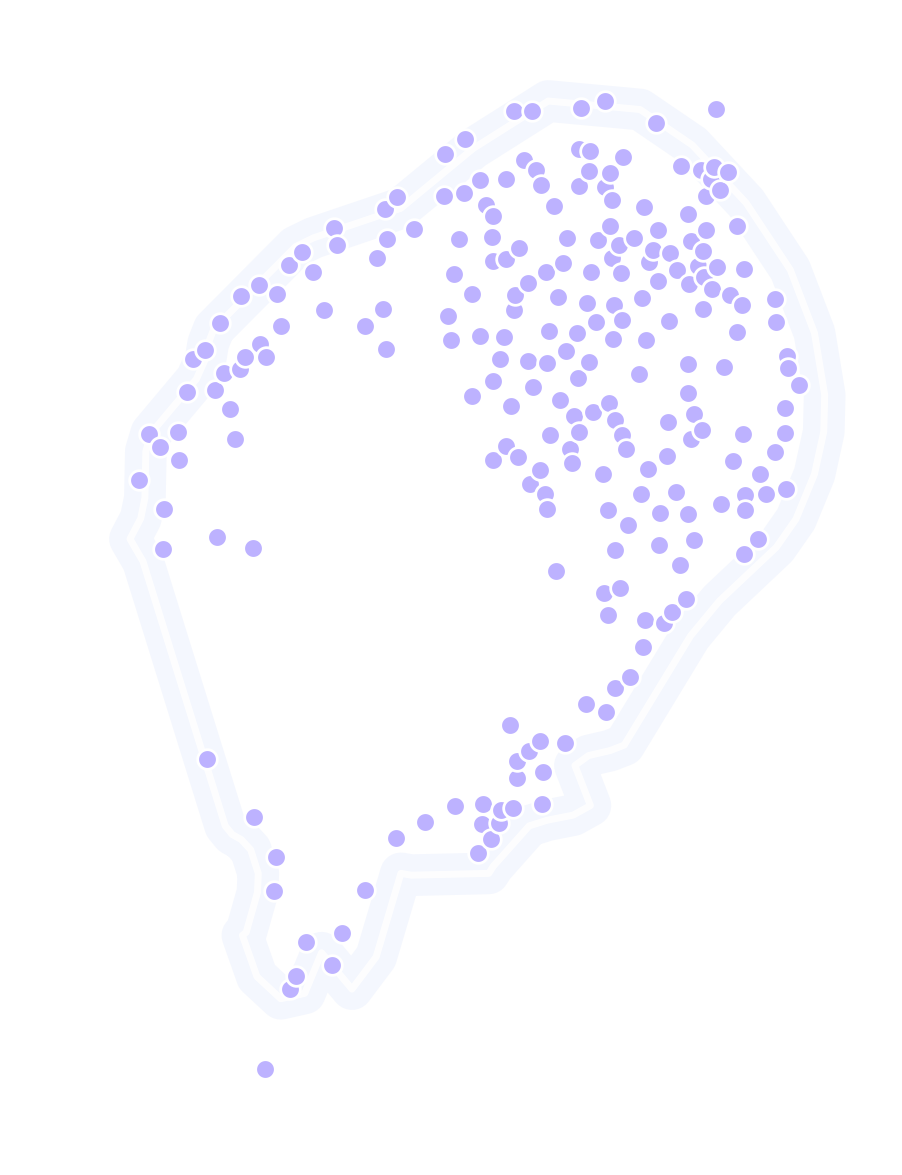

In [3]:
# Land creation ---------------------------------------------------------------
lnd = srv.Landscape(
    SAO_TOME_LL, 
    migrationMatrix=SAO_TOME_MIG,
    landLimits=SAO_LIMITS,
)
# Plots -----------------------------------------------------------------------
bbox = lnd.getBoundingBox()
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=200)
lnd.plotLandBoundary(fig, ax)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    os.path.join(OUT_PTH, '{}.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

### Exporting landscape

To export our generated landscape to disk, we can simply call one of our helper functions:

In [4]:
srv.dumpLandscape(lnd, OUT_PTH, '{}_LND'.format(ID), fExt='pkl')

To re-load it for mode analyisis down the line, we can call:

In [5]:
lnd = srv.loadLandscape(OUT_PTH, '{}_LND'.format(ID), fExt='pkl')

## Optimization

In [6]:
TRPS_NUM = 10
# Defining Traps --------------------------------------------------------------
(initTyp, initFxd, initLon, initLat) = (
    [0]*TRPS_NUM, [False]*TRPS_NUM,
    uniform(*SAO_bbox[0], TRPS_NUM), uniform(*SAO_bbox[1], TRPS_NUM)
)
sid = [0]*(TRPS_NUM) 
traps = pd.DataFrame({
    'sid': sid,
    'lon': initLon, 'lat': initLat, 
    't': initTyp, 'f': initFxd
})
tKer = {0: {'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}
# Updating Landscape ----------------------------------------------------------
lnd.updateTraps(traps=traps, trapsKernels=tKer)
lnd.trapsSiteID = traps['sid'] # NEED TO FIX THIS IN PKG

In [7]:
# GA Settings -----------------------------------------------------------------
(GENS, POP_SIZE, VERBOSE) = (25, int(10*(lnd.trapsNumber*1.5)), True)
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)

In [8]:
# Setup and Run GA ------------------------------------------------------------
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lnd, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    optimFunction=srv.getDaysTillTrappedPseudoInverse,
    fitFuns={'inner': np.sum, 'outer': np.mean}
)

gen	nevals	min        	avg       	max        	std        	best	traps                                         
0  	150   	2.59548e+13	2.9376e+14	2.61387e+15	2.00191e+14	86  	[33, 154, 76, 172, 66, 212, 60, 224, 163, 157]
1  	92    	2.55601e+13	2.57481e+14	3.15019e+14	6.68724e+13	106 	[226, 218, 140, 73, 191, 57, 190, 59, 210, 212]
2  	86    	1.84164e+13	3.87043e+14	2.35287e+16	1.89865e+15	36  	[33, 198, 76, 226, 76, 212, 60, 224, 163, 157] 
3  	77    	1.79993e+13	2.07681e+14	1.36719e+15	1.57083e+14	80  	[196, 237, 169, 212, 118, 185, 46, 146, 22, 196]
4  	84    	1.79993e+13	1.82297e+14	1.94741e+15	2.21668e+14	72  	[196, 237, 169, 212, 118, 185, 46, 146, 22, 196]
5  	74    	1879.43    	9.5626e+13 	3.14336e+14	1.14278e+14	136 	[24, 154, 203, 172, 141, 212, 60, 59, 86, 157]  
6  	80    	1474.04    	1.02591e+14	2.54199e+15	2.39439e+14	60  	[41, 10, 28, 212, 113, 126, 195, 120, 115, 24]  
7  	81    	1426.7     	1.03527e+14	2.33563e+15	2.53263e+14	109 	[41, 10, 28, 212, 113, 126, 195, 131, 22

(<Figure size 1500x1500 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x285171a20>)

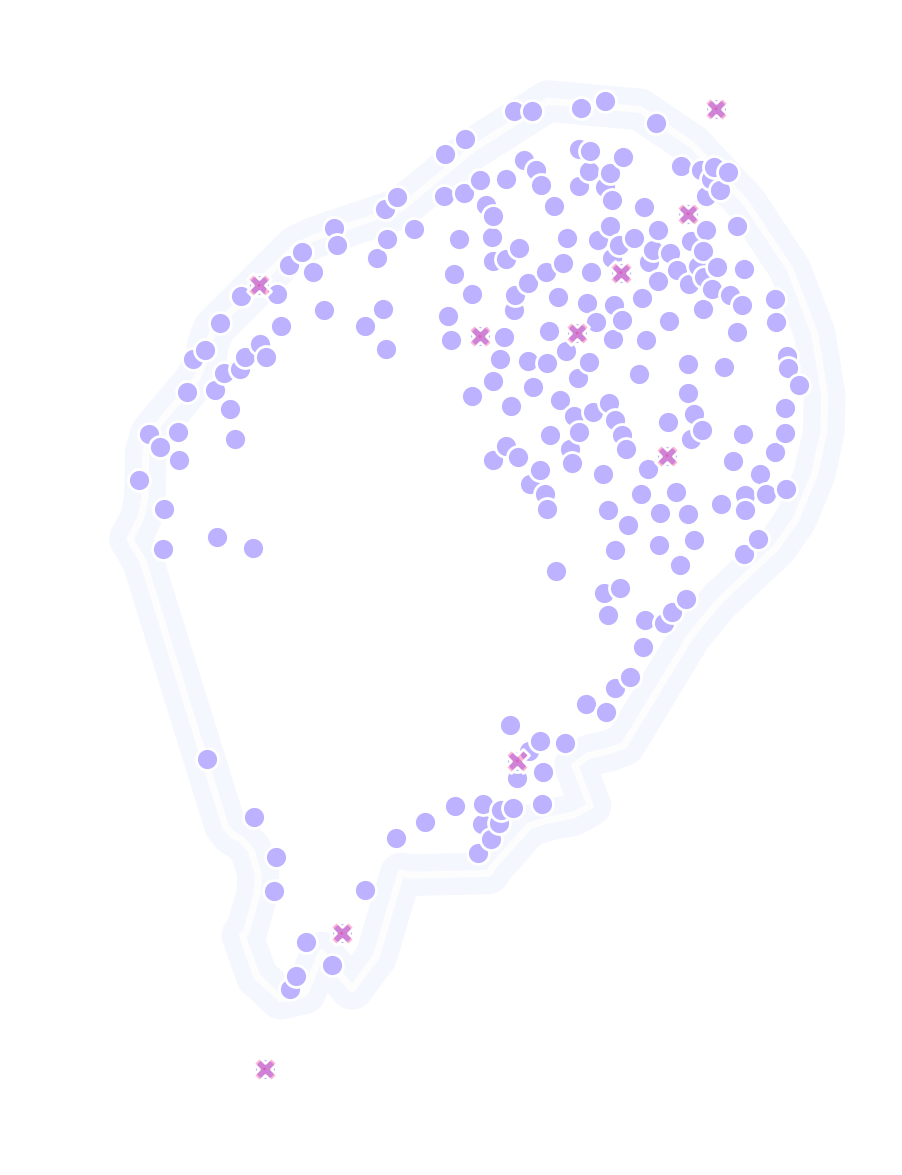

In [9]:
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=250)
# lnd.plotMigrationNetwork(
#     fig, ax, lineWidth=30, alphaMin=.25, alphaAmplitude=2.5
# )
lnd.plotTraps(
    fig, ax, 
    zorders=(30, 25), transparencyHex='55', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
# srv.plotFitness(fig, ax, min(dta['min']), fmt='{:.2f}')
lnd.plotLandBoundary(fig, ax)